# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Low Rank Adaptation of LLMs (LoRA) </strong> </p>

<p style = "text-align: center; font-family: 'Georgia', serif; font-size: 120%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;"> 
<b>Justin Cheigh & Spencer Huang</b>
</p>
<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;"> 
This notebook contains our final project, which looks at Low Rank Adaptation of LLMs (LoRA). At a high level, LoRA is a method of finetuning large language models. Specifically, we implement LoRA by scratch, which enables us to extend typical torch nn.Linear layers with an LinearLoRALayer. From here, we conduct a basic experiment on MNIST data. Our main experiment involved utilizing HF transformers to download a pretrained language model. We perform LoRA finetuning and analyze the results, with methods analogous to the original paper
</p>

<a id='1'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Background on Fine-Tuning</strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px;"> 

**Lo**w **R**ank **A**daptation of LLMs (LoRA) is a technique for finetuning LLMs in an efficint manner. At this point, it's unnecessary to comment on the effectiveness of modern LLMs. However, as there ability has increased, they have also scaled to be entirely large. Finetuning something like 7B LLama 3 is a pain without access to high quality compute, but the real problem is that fully finetuning models like GPT-4 is essentially impossible without probably hundreds of millions of dollars. 

However, we'd still like to finetune: there are plenty of use cases where specializing a general model is useful. For example, perhaps your corporation doesn't want to feed its data to GPT, but it may feel better about downloading an open source LLM and finetuning that. Or maybe you are developing a system to recognize zebras, so it's convenient to start with a model pretrained on ImageNet, which already has good classification capabilities. 

Thus, people have begun developing Parameter Efficient Fine Tuning (PEFT) techniques, since fine-tuning all model parameters would be prohibitively expensive. PEFT techniques fine tune a subset of the weights. Of course, this is beneficial from a compute standpoint, but importantly the performance of many of these techniques is also similar (if not better!) than fully finetuning. One may question how PEFT can ever be better than fully finetuning: a common problem with fully finetuning is catastrophic failure, where the model loses a subset of information is previously knew. 

Perhaps the most successful PEFT methods is Low Rank Adapation of LLMs (LoRA). In this deliverable, we aim to replicate the results of Hu et al's paper titled ["LoRA: Low-Rank Adaptation of Large Language Models"](https://arxiv.org/pdf/2106.09685). We also evaluate its performance on English to French translation tasks. 

<a id='1'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Introduction to LoRA </strong> </p>

The intuition for LoRA comes from past work, which assert that LLMs have low "intrinsic dimensionality" ([Li et al.](https://arxiv.org/abs/1804.08838), [Aghajanyan et al.](https://arxiv.org/abs/2012.13255)). At a high level, these papers conducted experiments that took a neural network, constrained it to a subspace of smaller dimension, and trained the model with this constraint. Performing this and measuring subspace dim vs. performance gives a basic sense of "intrinsic dimensionality", and the main takeaway is that LLMs are heavily over-parameterized (no surprise there). 

Thus, the authors of LoRA formalized this abstract sense of intrinsic dimension to something formal: the weight matrices are likely low rank. As a note, they are not literally low rank, as numerical imprecision prevents things like rank from being especially relevant (for example rank would likely change significantly if you are doing 8-bit quantization vs. 32-bit). From here, the authors further assumed that the finetune changes we'd like to made could also be represented well by a low rank matrix. 

Specifically, given a matrix $W \in \mathbb{R}^{d \times k}$, we'd like to learn $\Delta W \in \mathbb{R}^{d \times k}$, such that the finetuned result would be $W +\Delta W$. In other words, given an input $x$, the forward pass would be 
$$
h = (W + \Delta W)x = Wx + \Delta W x.
$$
This equality is actually interesting, it means that, if we fix the pretrained weights $W$, the $\Delta W x$ part is completely disjoint: thus we can easily add/remove various finetuning heads. The actual LoRA trick is to assume we may decompose 
$$
\Delta W = AB, 
$$
where $A \in \mathbb{R}^{d \times r}, B \in \mathbb{R}^{r \times k}$. Before we go further, what's the advantage here. Well, we can assume $d, k$ are large, whereas $r$ is very small. For example, with GPT-3 (175 billion params), $d, k$ may be larger than $12$ thousand, in which case this single $d \times d$ matrix will contain more than $144$ million parameters in it of itself. On the other hand, if $r$ was as low as say $4$ (and surprisingly, results can be good with $r$ as low as 4!), then $A, B$ will together contain around $50$ thousand parameters: in other words, this is a massive difference! Clearly, LoRA has a massive improvement on memory/compute as a result of this.

Typically, $B$ is initalized as $0$, wheraeas $A$ is initialized from a Gaussian. Finally, the finetune addition $\Delta W x$ is usually scaled by a hyperparameter $\frac{\alpha}{r}$, where we as per prior work set $\alpha = 0.1$. Personally, it's interesting that we scale this with $1/r$; it's not a priori clear why this is done. 

Additionally, in contrast to a lot of other finetune methods that were being used before LoRA, we are just adding one more matrix multiplication, and thus this doesn't add any inference latency. 


But, the real question is performance, and here is where LoRA really shines: it turns out to work incredibly well in practice. 

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px;"> 

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> LoRA Implementation</strong> </p>

In [1]:
import torch

class LoRALayer(torch.nn.Module):
    """
    Low-Rank Adaptation (LoRA) layer which applies linear transform to input,
    where the transform matrix Delta(W) is decomposed Delta(W) = AB. Here A, B
    are smaller matrices, i.e. we assume Delta(W) is low rank. 

    Args:
        rank (int)   
        alpha (float): Scaling 
        in_dim (int) : Dim of Input Vec
        out_dim (int): Dim of Output Vec

    Attributes:
        A (torch.nn.Parameter): Matrix of Dim (in_dim, rank).
        B (torch.nn.Parameter): Matrix of Dim (rank, out_dim).
        scaling (float)       : Scaling Factor 
    """
    def __init__(self, rank, alpha, in_dim, out_dim):
        super().__init__()
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.scaling = alpha / rank 

    def forward(self, x):
        """
        Forward pass of the LoRA layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_dim).
        """
        x = self.scaling * (x @ self.A @ self.B)
        return x


class LinearLoRALayer(torch.nn.Module):
    """
    Extends nn.Linear with a LoRA layer.

    Args:
        linear (torch.nn.Linear): Original linear layer to be extended.
        rank (int)              : The rank for the low-rank matrices in the LoRA layer.
        alpha (float)           : Scaling factor for the LoRA output.

    Attributes:
        linear (torch.nn.Linear): Standard linear layer.
        lora (LoRALayer)        : Low-rank adaptation layer.
    """
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            rank=rank,
            alpha=alpha,
            in_dim=linear.in_features,
            out_dim=linear.out_features)

    def forward(self, x):
        """
        Forward pass of the LinearLoRALayer, which combines outputs from the original linear layer and the LoRA layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features) where `in_features` should match `self.linear.in_features`.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features) where `out_features` is `self.linear.out_features`.

        Uses distributive law: (W + Delta(W))x = (W + AB)x = Wx + ABx, which enables quick swapping or LoRA layers
        """
        return self.linear(x) + self.lora(x)

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> MNIST Proof of Concept </strong> </p>

This is a very simple situation, just to demonstrate that our implementation works as expected. Here, we take the MNIST dataset, train on $p$ percent of it, then split the remaining $1-p$ of the dataset into $10$ finetune datasets, one for each digit (so each finetune dataset is only comprised of one digit, which obviously doesn't make sense). We then show how easily one can swap LoRA heads by finetuning for each of the 10 datasets simultaneously.

In [3]:
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from tqdm import tqdm

In [4]:
### transform object to turn to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### load mnist data
mnist_dataset = datasets.MNIST(root='./data', download=True, transform=transform)

### split
train_size    = int(0.4 * len(mnist_dataset))
finetune_size = int(0.5 * len(mnist_dataset))
test_size     = len(mnist_dataset) - train_size - finetune_size

train_data, finetune_data, test_data = random_split(mnist_dataset, [train_size, finetune_size, test_size])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5869969.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 884176.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 6979629.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2148232.83it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 100) 
        self.fc2 = nn.Linear(100, 10)     

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = torch.zeros(10, 10)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy, confusion_matrix.diag() / confusion_matrix.sum(1)

In [7]:
model = SimpleNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### train initial model
for epoch in tqdm(range(2)): 
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

initial_loss, initial_accuracy, category_accuracy = evaluate(model, test_loader, criterion)

100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


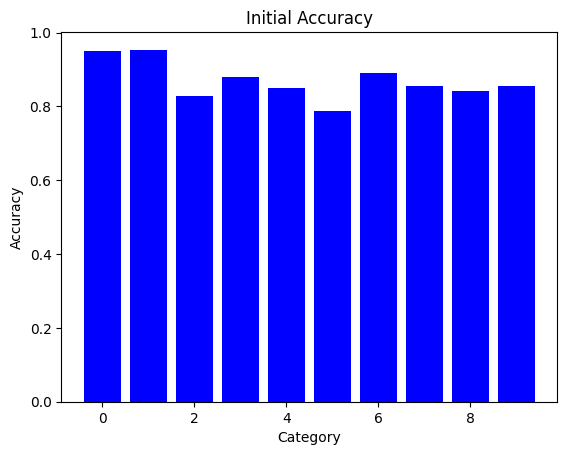

In [8]:
plt.bar(list(range(10)), category_accuracy.numpy(), color='blue')
plt.title('Initial Accuracy')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.show()

In [9]:

category_indices = defaultdict(list)

for idx, (_, label) in enumerate(finetune_data.dataset):
    if idx in finetune_data.indices:
        category_indices[label].append(idx)

### create finetune loaders
finetune_loaders = []
for i in range(10):
    if category_indices[i]: 
        subset = Subset(finetune_data.dataset, category_indices[i])
        finetune_loaders.append(DataLoader(subset, batch_size=64, shuffle=True))
    else:
        finetune_loaders.append(None) 

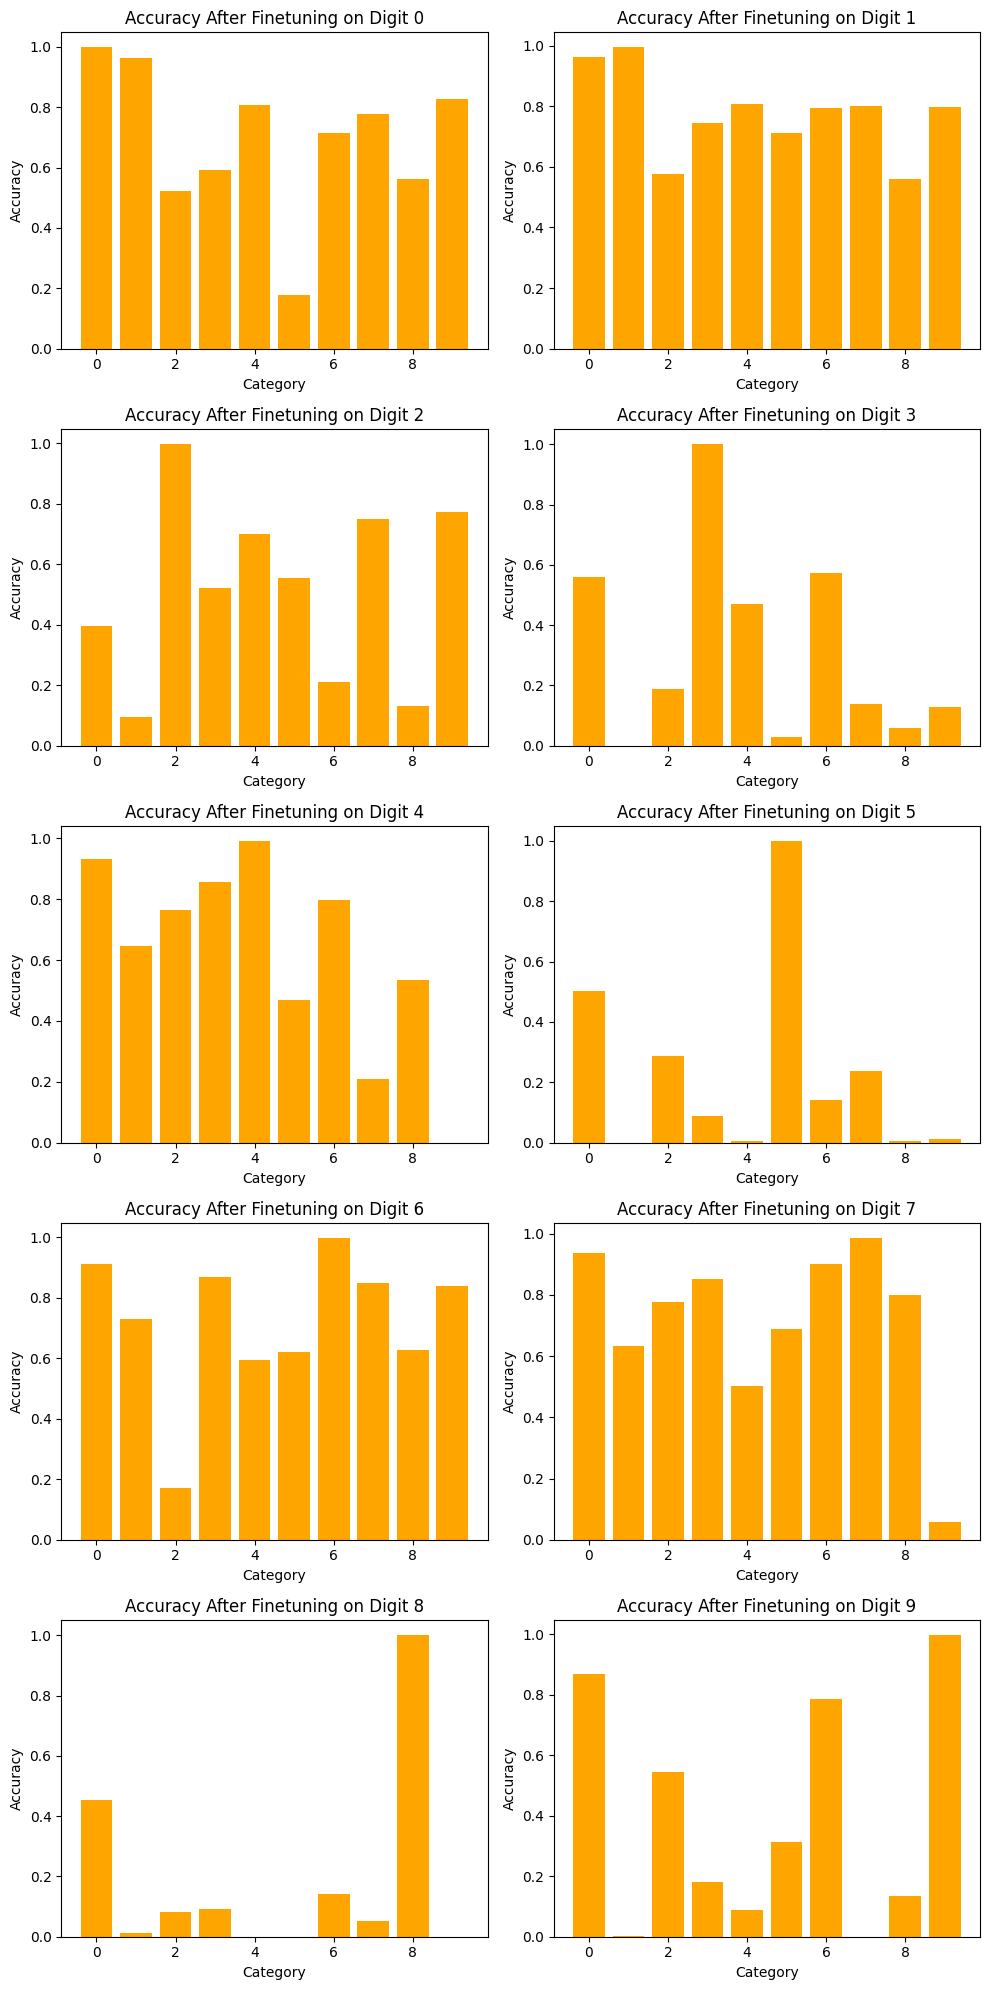

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
for i in range(10):
    finetune_model = SimpleNN()
    ### start with pretrained model
    finetune_model.load_state_dict(model.state_dict())  
    
    ### Replace with LoRA layer and create new optimizer for LoRA parameters
    finetune_model.fc2 = LinearLoRALayer(finetune_model.fc2, rank=3, alpha=1)
    lora_params = list(finetune_model.fc2.lora.parameters())
    optimizer = torch.optim.SGD(lora_params, lr=0.01) 
    
    # freeze params except LoRA (this gets buggy idrk why)
    for param in finetune_model.parameters():
        param.requires_grad = False  
    for param in lora_params:
        param.requires_grad = True  
    
    for epoch in range(5):
        finetune_model.train()
        for data, target in finetune_loaders[i]:
            optimizer.zero_grad()
            output = finetune_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    _, _, finetune_accuracy = evaluate(finetune_model, test_loader, criterion)
    ax = axes[i // 2, i % 2]
    ax.bar(list(range(10)), finetune_accuracy.numpy(), color='orange')
    ax.set_title(f'Accuracy After Finetuning on Digit {i}')
    ax.set_xlabel('Category')
    ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

As you can see, the finetuning works as expected, but this sort of horrible training scheme definitely enables catastrophic forgetting. 

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Main Experiment </strong> </p>

For our main experiment, we aim to finetune a language model to translate between English (en) to French (fr). Specifically, we begin by defining a Model class that takes the Helsinki-NLP/opus-mt-en-fr (a language model pretrained to translate between English to French) and replaces any attention layers with our Linear LoRA layers if specified.

The experiment then fully finetunes a model, and then finetunes via LoRA with ranks in 1,2,4,8,16,32,64. We trained using 2 GPUs (thanks APPA) and ran the experiment $3$ times (each took multiple hours, and Justin screwed it up at least twice). 

In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, pipeline
import evaluate
import numpy as np
import time 
import os 
import pandas as pd 

class ModelConfig:
    
    def __init__(self, checkpoint='Helsinki-NLP/opus-mt-en-fr', lora=False, rank=None, alpha=0.1):
        if checkpoint != 'Helsinki-NLP/opus-mt-en-fr':
            raise ValueError(f'Only supporting Helsinki-NLP for now.')

        self.model     = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
        self.lora      = lora
        self.rank      = rank
        self.alpha     = alpha 

        if self.lora:
            print(f'Using LoRA')
            if rank is None:
                raise ValueError(f'If lora == True, rank cannot be None')

            elif not isinstance(rank, int):
                raise ValueError(f'If lora == True, rank must be an integer')

            elif not rank > 0:
                raise ValueError(f'If lora == True, rank must a positive integer')

            print(f'Applying LoRA Layers')
            self.apply_lora()

    def apply_lora(self):
        """ 
        applies LoRA layers to model by:
            - replaces attention layers with LinearLoRALayer
            - freezes non-LoRA params
        """
        ### freeze all 
        for param in self.model.parameters():
            param.requires_grad = False

        ### replce attn layers
        for name, module in list(self.model.named_modules()):
            if 'attn' in name and isinstance(module, nn.Linear):
                parent_name, child_name = name.rsplit('.', 1)
                parent_module = dict(self.model.named_modules())[parent_name]
                new_lora_layer = LinearLoRALayer(module, self.rank, self.alpha)
                setattr(parent_module, child_name, new_lora_layer)

        ### set A/B matrices to trainable
        for name, module in self.model.named_modules():
            if isinstance(module, LinearLoRALayer):
                for param in module.parameters():
                    ### if self.A or self.B
                    if list(param.size()) in [[512, self.rank], [self.rank, 512]]: 
                        param.requires_grad = True


In [16]:
"""
Resources:
https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/translation.ipynb#scrollTo=VVOuV-q6fibd
"""
DATA_PATH = '/mnt/storage/jcheigh/cs381-final/data'

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def run_exp(
    checkpoint   = 'Helsinki-NLP/opus-mt-en-fr',
    tgt_lang     = 'fr',
    dataset_name = 'kde4',
    testing      = True
    ):
    ### testing runs quick for quick eval
    exp_start = time.time()
    print(f'Beginning Experiment on Language: {tgt_lang}')
    
    ### instantiate tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    print(f'Loading kde4 Dataset...')
    data_start     = time.time()
    ### raw data
    data           = load_dataset(dataset_name, lang1='en', lang2=tgt_lang)
    ### dataset object
    dataset        = data['train'].train_test_split(train_size=0.95, seed=1)
    print(f'Loading Dataset Took: {round(time.time() - data_start, 2)} Seconds')

    def tokenize(data):
        ### tokenize using tokenizer- truncate to 128 tokens
        return tokenizer(
            [datum['en'] for datum in data['translation']],
            text_target = [datum[tgt_lang] for datum in data['translation']],
            max_length = 128,
            truncation = True
            )
    print(f'Tokenizing Dataset...')
    token_start = time.time()
    tokenized_datasets = dataset.map(
        tokenize,
        batched=True,
        remove_columns=dataset["train"].column_names,
        )
    print(f'Tokenizing Dataset Took: {round(time.time() - token_start, 2)} Seconds')

    ### bleu metric 
    metric = evaluate.load("sacrebleu")

    def compute_metrics(eval_preds):
        ### code from source above 
        preds, labels = eval_preds
        
        if isinstance(preds, tuple):
            preds = preds[0]

        decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
        ### skip special tokens
        labels         = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        result = metric.compute(
            predictions=[pred.strip() for pred in decoded_preds], 
            references=[[label.strip()] for label in decoded_labels]
            )
        return {"bleu": result["score"]}

    ### define models- 1 base + different lora 
    model_configs = [ModelConfig()] + [ModelConfig(lora=True, rank=r) for r in [1,2,4,8,16,32,64]]
    
    for model_config in model_configs:
        run_start = time.time()
        model     = model_config.model

        if model_config.lora:
            print(f'\n Running LoRA with Rank {model_config.rank}')
            name = f'en-{tgt_lang}-lora-{model_config.rank}'
        else:
            print(f'Running Base Finetune')
            name = f'en-{tgt_lang}-base'

        num_trainable = count_trainable_params(model)
        print(f'There are {num_trainable} trainable params')

        ### for batching stuff
        data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

        if testing:
            args = Seq2SeqTrainingArguments(
                output_dir=f"{DATA_PATH}/{name}",
                evaluation_strategy="steps",  
                eval_steps=25, # steps before eval
                learning_rate=2e-5,
                per_device_train_batch_size=150, # increase to max gpu 
                per_device_eval_batch_size=10, #idk why but the eval is super messed up
                weight_decay=0.01,
                save_total_limit=1,
                num_train_epochs=1,  
                max_steps=50, #steps before done
                predict_with_generate=True,
                fp16=True #idk apparently just better 
                )
        else:
            args = Seq2SeqTrainingArguments(
                output_dir=f"{DATA_PATH}/{name}",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                learning_rate=2e-5,
                per_device_train_batch_size=150,
                per_device_eval_batch_size=10,
                weight_decay=0.01,
                save_total_limit=1,
                num_train_epochs=3,
                predict_with_generate=True,
                fp16=True,
                )

        ### trainer object 
        trainer = Seq2SeqTrainer(
            model,
            args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            )
        ### train    
        trainer.train()

        result     = trainer.evaluate()
        train_time = round(time.time() - run_start, 2)
        bleu_score = result.get('eval_bleu', 0)
    
        results_path = f"{DATA_PATH}/results.csv"

        ### save data 
        if not os.path.exists(results_path):
            df = pd.DataFrame(columns=['tgt_lang', 'bleu', 'lora', 'rank', 'alpha', 'train_time'])
        else:
            df = pd.read_csv(results_path)

        lora, rank, alpha = model_config.lora, model_config.rank, model_config.alpha

        ### add data 
        if lora:
            new_row = pd.DataFrame([{'tgt_lang': tgt_lang, 'bleu': bleu_score, 'lora': lora, 'rank': rank, 'alpha': alpha, 'train_time': train_time}])
        else:
            new_row = pd.DataFrame([{'tgt_lang': tgt_lang, 'bleu': bleu_score, 'lora': lora, 'rank': None, 'alpha': None, 'train_time': train_time}])

        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(results_path, index=False)

        print(f'Completed Run Took {train_time} Seconds')

    print(f"Completed Experiment on Language: {tgt_lang}")
    print(f'Experiment Took: {round(time.time() - exp_start,2)} Seconds')

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Experiment Logs </strong> </p>

A few things to note in the logs before are the drastic change in trainable parameters. We'd expect that as rank increases, performance increases, whereas time decreases. I'm not exactly sure why, but we don't exactly see this trend.

```
Running Base Finetune
There are 74609664 trainable params
{'loss': 1.253, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.0333207845687866, 'eval_bleu': 48.60905944429018, 'eval_runtime': 629.0773, 'eval_samples_per_second': 16.705, 'eval_steps_per_second': 0.836, 'epoch': 1.0}
{'loss': 1.0674, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 0.9721274971961975, 'eval_bleu': 50.54475064636751, 'eval_runtime': 563.9026, 'eval_samples_per_second': 18.636, 'eval_steps_per_second': 0.933, 'epoch': 2.0}
{'loss': 1.0015, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 0.9573653936386108, 'eval_bleu': 50.49351847604458, 'eval_runtime': 549.0189, 'eval_samples_per_second': 19.141, 'eval_steps_per_second': 0.958, 'epoch': 3.0}
{'train_runtime': 3297.7821, 'train_samples_per_second': 181.635, 'train_steps_per_second': 0.606, 'train_loss': 1.074104240348747, 'epoch': 3.0}
Completed Run Took 3858.59 Seconds

 Running LoRA with Rank 1
There are 73728 trainable params
{'loss': 1.7838, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.685339331626892, 'eval_bleu': 40.35171237499122, 'eval_runtime': 642.9429, 'eval_samples_per_second': 16.345, 'eval_steps_per_second': 0.818, 'epoch': 1.0}
{'loss': 1.7498, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6604071855545044, 'eval_bleu': 41.031848173587015, 'eval_runtime': 674.3667, 'eval_samples_per_second': 15.584, 'eval_steps_per_second': 0.78, 'epoch': 2.0}
{'loss': 1.7266, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6535604000091553, 'eval_bleu': 41.22414254657166, 'eval_runtime': 693.1156, 'eval_samples_per_second': 15.162, 'eval_steps_per_second': 0.759, 'epoch': 3.0}
{'train_runtime': 3410.303, 'train_samples_per_second': 175.642, 'train_steps_per_second': 0.586, 'train_loss': 1.7455403401448324, 'epoch': 3.0}
Completed Run Took 4095.19 Seconds

 Running LoRA with Rank 2
There are 147456 trainable params
{'loss': 1.7902, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6946648359298706, 'eval_bleu': 40.33589693937516, 'eval_runtime': 629.1132, 'eval_samples_per_second': 16.704, 'eval_steps_per_second': 0.836, 'epoch': 1.0}
{'loss': 1.7607, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6701887845993042, 'eval_bleu': 40.71219361648992, 'eval_runtime': 656.8802, 'eval_samples_per_second': 15.998, 'eval_steps_per_second': 0.801, 'epoch': 2.0}
{'loss': 1.7375, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6630319356918335, 'eval_bleu': 40.918053526977666, 'eval_runtime': 662.0263, 'eval_samples_per_second': 15.874, 'eval_steps_per_second': 0.795, 'epoch': 3.0}
{'train_runtime': 3351.6956, 'train_samples_per_second': 178.713, 'train_steps_per_second': 0.596, 'train_loss': 1.755132665624609, 'epoch': 3.0}
Completed Run Took 4020.14 Seconds

 Running LoRA with Rank 4
There are 294912 trainable params
{'loss': 1.7838, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6849136352539062, 'eval_bleu': 40.447268712431764, 'eval_runtime': 633.4259, 'eval_samples_per_second': 16.591, 'eval_steps_per_second': 0.83, 'epoch': 1.0}
{'loss': 1.7497, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6598087549209595, 'eval_bleu': 40.77566171785493, 'eval_runtime': 663.8318, 'eval_samples_per_second': 15.831, 'eval_steps_per_second': 0.792, 'epoch': 2.0}
{'loss': 1.7264, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6528223752975464, 'eval_bleu': 40.858775054898715, 'eval_runtime': 680.9251, 'eval_samples_per_second': 15.433, 'eval_steps_per_second': 0.772, 'epoch': 3.0}
{'train_runtime': 3382.8112, 'train_samples_per_second': 177.069, 'train_steps_per_second': 0.591, 'train_loss': 1.7453259839429274, 'epoch': 3.0}
Completed Run Took 4059.83 Seconds

 Running LoRA with Rank 8
There are 589824 trainable params
{'loss': 1.7855, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6873962879180908, 'eval_bleu': 40.39433619168115, 'eval_runtime': 623.2329, 'eval_samples_per_second': 16.862, 'eval_steps_per_second': 0.844, 'epoch': 1.0}
{'loss': 1.7526, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6626920700073242, 'eval_bleu': 40.857982873095885, 'eval_runtime': 701.0859, 'eval_samples_per_second': 14.99, 'eval_steps_per_second': 0.75, 'epoch': 2.0}
{'loss': 1.7293, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.655786156654358, 'eval_bleu': 40.95703965126671, 'eval_runtime': 704.7995, 'eval_samples_per_second': 14.911, 'eval_steps_per_second': 0.746, 'epoch': 3.0}
{'train_runtime': 3438.5746, 'train_samples_per_second': 174.198, 'train_steps_per_second': 0.581, 'train_loss': 1.747941697801317, 'epoch': 3.0}
Completed Run Took 4143.76 Seconds

 Running LoRA with Rank 16
There are 1179648 trainable params
{'loss': 1.7857, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6879750490188599, 'eval_bleu': 40.40320661446827, 'eval_runtime': 618.8875, 'eval_samples_per_second': 16.98, 'eval_steps_per_second': 0.85, 'epoch': 1.0}
{'loss': 1.7528, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6632108688354492, 'eval_bleu': 40.832939254681946, 'eval_runtime': 657.5932, 'eval_samples_per_second': 15.981, 'eval_steps_per_second': 0.8, 'epoch': 2.0}
{'loss': 1.7293, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6562414169311523, 'eval_bleu': 40.93794022278032, 'eval_runtime': 688.9648, 'eval_samples_per_second': 15.253, 'eval_steps_per_second': 0.763, 'epoch': 3.0}
{'train_runtime': 3376.7098, 'train_samples_per_second': 177.389, 'train_steps_per_second': 0.592, 'train_loss': 1.7480255218597505, 'epoch': 3.0}
Completed Run Took 4065.21 Seconds

 Running LoRA with Rank 32
There are 2359296 trainable params
{'loss': 1.7849, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6867729425430298, 'eval_bleu': 40.29785621224416, 'eval_runtime': 636.639, 'eval_samples_per_second': 16.507, 'eval_steps_per_second': 0.826, 'epoch': 1.0}
{'loss': 1.7513, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.6619408130645752, 'eval_bleu': 40.7865880621523, 'eval_runtime': 666.3542, 'eval_samples_per_second': 15.771, 'eval_steps_per_second': 0.789, 'epoch': 2.0}
{'loss': 1.7279, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6549667119979858, 'eval_bleu': 40.92316081818053, 'eval_runtime': 664.6994, 'eval_samples_per_second': 15.81, 'eval_steps_per_second': 0.791, 'epoch': 3.0}
{'train_runtime': 3384.7537, 'train_samples_per_second': 176.968, 'train_steps_per_second': 0.59, 'train_loss': 1.7467198643956456, 'epoch': 3.0}
Completed Run Took 4046.01 Seconds

 Running LoRA with Rank 64
There are 4718592 trainable params
{'loss': 1.7856, 'learning_rate': 1.4994994994994995e-05, 'epoch': 0.75}
{'eval_loss': 1.6878669261932373, 'eval_bleu': 40.38664101998107, 'eval_runtime': 627.6507, 'eval_samples_per_second': 16.743, 'eval_steps_per_second': 0.838, 'epoch': 1.0}
{'loss': 1.7527, 'learning_rate': 9.989989989989992e-06, 'epoch': 1.5}
{'eval_loss': 1.663216471672058, 'eval_bleu': 40.76364216651539, 'eval_runtime': 669.4086, 'eval_samples_per_second': 15.699, 'eval_steps_per_second': 0.786, 'epoch': 2.0}
{'loss': 1.7293, 'learning_rate': 4.984984984984985e-06, 'epoch': 2.25}
{'eval_loss': 1.6562819480895996, 'eval_bleu': 40.88997733230611, 'eval_runtime': 669.1549, 'eval_samples_per_second': 15.705, 'eval_steps_per_second': 0.786, 'epoch': 3.0}
{'train_runtime': 3395.6299, 'train_samples_per_second': 176.401, 'train_steps_per_second': 0.588, 'train_loss': 1.7479553833618775, 'epoch': 3.0}
Completed Run Took 4052.0 Seconds
Completed Experiment on Language: fr
Experiment Took: 32363.76 Seconds
'''

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Analysis of Experiment </strong> </p>

We now move to analysis of the experiments. 

In [18]:
import os 
import pandas as pd
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

MAIN_PATH = f'/mnt/storage/jcheigh/cs381-final'
SRC_PATH  = f'{MAIN_PATH}/src'
DATA_PATH =f'{MAIN_PATH}/data'
PLOT_PATH = f'{DATA_PATH}/plots'
CSV_PATH  = f'{DATA_PATH}/results.csv'

### better ways to do this but whatever
models_map = {
    'base' : 'en-fr-base',
    'lora1' : 'en-fr-lora-1',
    'lora2' : 'en-fr-lora-2',
    'lora4' : 'en-fr-lora-4',
    'lora8' : 'en-fr-lora-8',
    'lora16' : 'en-fr-lora-16',
    'lora32' : 'en-fr-lora-32',
    'lora64' : 'en-fr-lora-64'
}
model_path_map = {}

for model, name in models_map.items():
    path = f'{DATA_PATH}/{name}'
    checkpoint = [dir for dir in os.listdir(path) if 'checkpoint' in dir][0]
    model_path = f'{path}/{checkpoint}/pytorch_model.bin'

    if not os.path.exists(model_path):
        raise Exception('failed path')

    model_path_map[model] = model_path
    print(f'Model: {model}, Path: {model_path}')

Model: base, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-base/checkpoint-1998/pytorch_model.bin
Model: lora1, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-1/checkpoint-1998/pytorch_model.bin
Model: lora2, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-2/checkpoint-1998/pytorch_model.bin
Model: lora4, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-4/checkpoint-1998/pytorch_model.bin
Model: lora8, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-8/checkpoint-1998/pytorch_model.bin
Model: lora16, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-16/checkpoint-1998/pytorch_model.bin
Model: lora32, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-32/checkpoint-1998/pytorch_model.bin
Model: lora64, Path: /mnt/storage/jcheigh/cs381-final/data/en-fr-lora-64/checkpoint-1998/pytorch_model.bin


In [19]:
def load_checkpoint(name):
    path = model_path_map[name]
    return torch.load(path, map_location='cpu')

base = load_checkpoint('base')
lora8 = load_checkpoint('lora8')

In [20]:
def get_weights(mat_name, model_name='lora8'):
    model = load_checkpoint(model_name)
    for name, param in model.items():
        if name == mat_name:
            return param 

    return f"Couldn't find {mat_name}"

def select_weights(
    coders=['encoder'],
    layers=[1],
    attn_type = ['self_attn'],
    proj = ['q'],
    lora=True,
    model='lora8'
    ):
    names = [f'model.{coder}.layers.{i}.{attn}.{pro}_proj' for coder in coders for i in layers for attn in attn_type for pro in proj]
    if lora:
        return {
                name : {
                    'weight' : get_weights(f'{name}.linear.weight', model),
                    'bias'   : get_weights(f'{name}.linear.bias', model),
                    'loraA'  : get_weights(f'{name}.lora.A', model),
                    'loraB'  : get_weights(f'{name}.lora.B', model),       
                    } for name in names
                }
    else:
        return {
                name : {
                    'weight' : get_weights(f'{name}.linear.weight', model),
                    'bias'   : get_weights(f'{name}.linear.bias', model)
                } for name in names
        }

def get_all_weights(model):
    return select_weights(coders=['encoder', 'decoder'],
    layers=[0,1,2,3,4,5], attn_type=['self_attn'], proj=['q', 'k', 'v', 'out'])

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Initial Baselines  </strong> </p>

We assessed model performance of LoRA on translation using BLEU -- Bilingual Evaluation Understudy -- is a common metric used in NLP. Scores range from 0-100, where above 30 is generally considered good (our pretrained model already does better than 30, shhh...). 

In our case, we were interested in the performance of LoRA in the translation of English to French. For each of the different LoRA rank models, we measured BLEU performance and training time. Additionally, we measured performance and training time for the full baseline model for comparison. The evaluative measures are shown in the dataframe below:

In [23]:
df = pd.read_csv(CSV_PATH)
df['train_time'] = df['train_time'].combine_first(df['train_time '])
df = df.drop('train_time ', axis=1)
df

,tgt_lang,bleu,lora,rank,alpha,train_time
0,fr,50.493518,False,NaN,NaN,3858.59
1,fr,41.224143,True,1.0,0.1,4095.19
2,fr,40.918054,True,2.0,0.1,4020.14
3,fr,40.858775,True,4.0,0.1,4059.83
4,fr,40.957040,True,8.0,0.1,4143.76
5,fr,40.937940,True,16.0,0.1,4065.21
6,fr,40.923161,True,32.0,0.1,4046.01
7,fr,40.889977,True,64.0,0.1,4052.00


We start first with BLEU versus the LoRA rank, as shown in Figure 1 below. The baseline model BLEU of 50.49 is shown with the dotted red line; the individual LoRA models are plotted in blue by rank. Yet none of the LoRA models of any rank score particularly close to the baseline BLEU. Additionally, performance does not seem to increase with rank, as we would have expected; all of our LoRA models score between 40.8 and 41.2. Overall, the disappointing performance of the LoRA models may be explained by the fact that we implemented LoRA by scratch, which ignores optimizations that likely would have increased the performance of the models. Honestly, it's prob likely we just had a bug also...

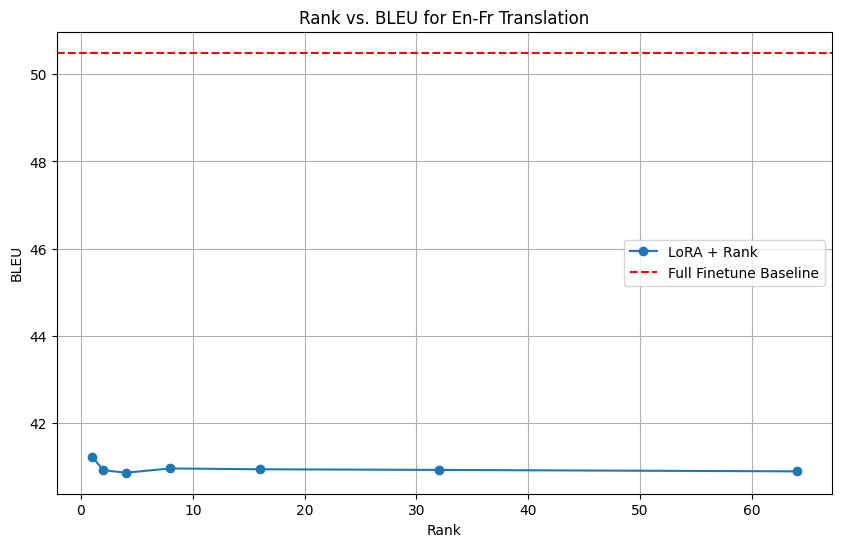

In [24]:
baseline_bleu = df[df['rank'].isna()]['bleu'].iloc[0]

plt.figure(figsize=(10, 6))

df_plot = df[df['bleu'].notna() & df['rank'].notna()]

plt.plot(df_plot['rank'].values, df_plot['bleu'].values, marker = 'o', label='LoRA + Rank')
plt.axhline(y=baseline_bleu, color='r', linestyle='--', label='Full Finetune Baseline')

plt.title('Rank vs. BLEU for En-Fr Translation')
plt.xlabel('Rank')
plt.ylabel('BLEU')
plt.legend()

plt.grid(True)
plt.show()


We move next to normalized training time versus rank, as shown in Figure 2 below. Again, the baseline model is shown with a red dotted line, while the LoRA times are plotted in blue against their rank. Again, training time for all of hte models seems to be uncorrelated with the rank of the matrix. Additionally, all of the LoRA models take longer to train than the baseline model. This is unintuitive, since the baseline fine-tuning model should theoretically have the largest number of trainable parameters and thus take the longest to run. However, by implementing LoRA from scratch, we likely did not optimize LoRA's efficiency, thus resulting in slower performance. 

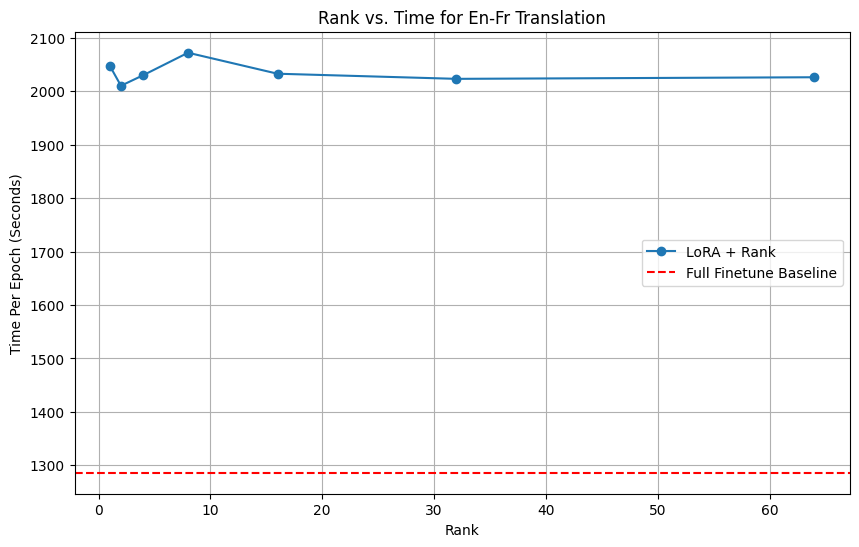

In [25]:
df['normalized_time'] = df['train_time'] / 2
df.loc[df['rank'].isna(), 'normalized_time'] = df['train_time'] / 3

plt.figure(figsize=(10, 6))
plt.plot(df['rank'].values, df['normalized_time'].values, marker='o', label='LoRA + Rank')
plt.axhline(y=df[df['rank'].isna()]['normalized_time'].iloc[0], color='r', linestyle='--', label='Full Finetune Baseline')

plt.title('Rank vs. Time for En-Fr Translation')
plt.xlabel('Rank')
plt.ylabel('Time Per Epoch (Seconds)')
plt.legend()

plt.grid(True)
#plt.savefig(f'{PLOT_PATH}/rank_vs_time.jpg')
plt.show()

## Subspace Similarity

An important contribution by Hu et al was their analysis of subspace similarity. The underlying idea is that if we only "need" rank $r*$, where $r* < r$, a significant amount of information from the rank $r$ matrix can be captured in just $r*$ dimensions. Mathematically, this can be quantified by the normalized subspace similarity as measured by Grassman distances. Given two learned adaption matrices of different rank using the same pretrained model (for example, for $r=8$ and $r=64$ we would have $A_{r=8}$ and $A_{r=64}$), we can perform singular value decomposition and obtain the right-singular unitary matrices $U_{A_{r=8}}$ and $U_{A_{r=64}}$. These decompositions serve to quantify how much of the subspace spanned by the top $i$ singular vectors in  $U_{A_{r=8}}$ is also contained in the subspace spanned by the top $j$ singular vectors in $U_{A_{r=64}}$. This measure is quantified by the Grassman distances, defined as 
$$\phi (A_{r=8}, A_{r=64}, i , j) = \frac{||U^{i \top}_{A_{r=8}}U^{j}_{A_{r=64}}||^2_F}{min(i,j)} \in [0,1]$$
where $\phi = 1$ represents complete overlap and $\phi = 0$ represents no overlap. The authors' subspace similarity is shown below:

![image.png](image.png)


Interestingly, there is significant overlap between the top one singular vector of $A_{r=8}$ and $A_{r=64}$. Normalized similarity is greater than 0.5, helping to explain why $r=1$ performs well. This overlap is much less pronounced for other vectors.



We were interested in what the subspace similarities looked like for our LoRA models. We implemented the adaptation matrices and Grassman distances for all pairs of our models. The figures are shown below with a subspace similarity matrix for each pair of adaptation matrices. 

In [28]:
def get_mats(
    coders=['encoder'],
    layers=[4],
    attn_type=['self_attn'],
    proj=['q'],
    models = ['lora8'],
    ranks=[8]
    ):
    res = {}
    for rank, model in zip(ranks, models):
        selected = select_weights(coders=coders, layers=layers, attn_type=attn_type, proj=proj, model=model)
        for name, json in selected.items():
            lora = json['loraA']
            res[rank] = lora

    return res
        
loraA_mats = get_mats(coders=['decoder'], proj='v', 
                      models=['lora1', 'lora2', 'lora4', 'lora8','lora16', 'lora32', 'lora64'], 
                      ranks=[8, 16, 32])

In particular, the similarity matrix between the rank 8 and rank 64 LoRA models show a high degree of similarity for the first singular vector, confirming the results found in Hu et al's paper. However, the rest of the similarity matrix does not match the decreasing similarity trend as $i$ and $j$ increase. In particular, we find that the similarity is most different for the second to fifth singular vectors for the rank 8 matrix. This trend, which also appears in other similarity matrices between different ranks, may be a result of implementing LoRA from scratch. 

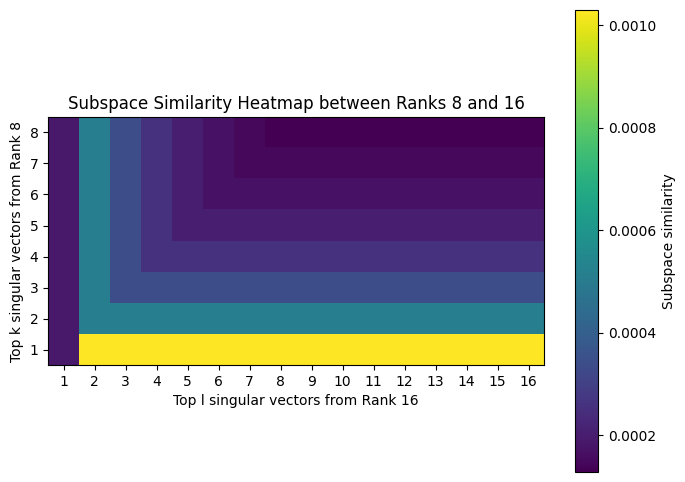

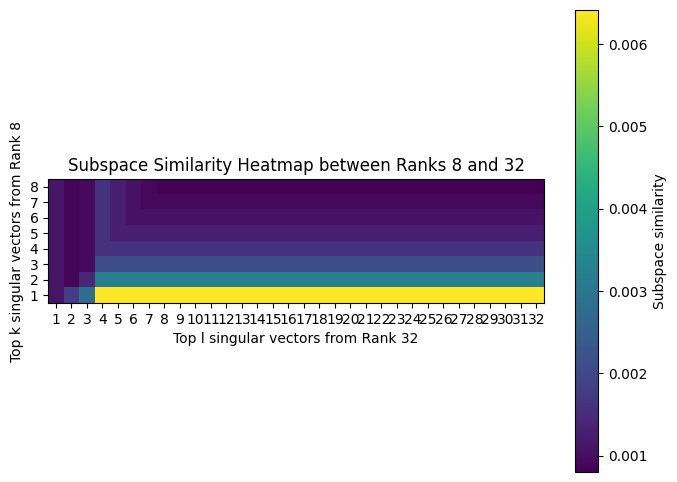

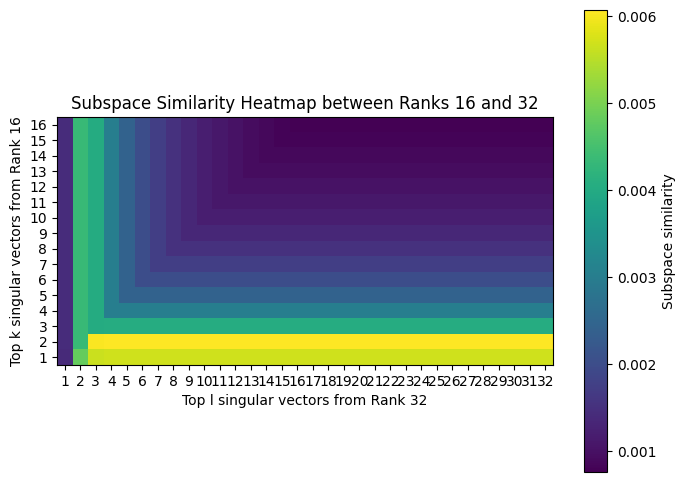

In [29]:
def compute_subspace_sim(mats):

    ranks = sorted(mats.keys())
    
    for i, rank_i in enumerate(ranks):
        for rank_j in ranks[i+1:]: 
            A1 = mats[rank_i]
            A2 = mats[rank_j]
            
            # SVD
            U1, _, _ = np.linalg.svd(A1, full_matrices=False)
            U2, _, _ = np.linalg.svd(A2, full_matrices=False)
            
            max_i = rank_i
            max_j = rank_j
            
            phi_matrix = np.zeros((max_i, max_j))
            
            for k in range(1, max_i + 1):
                for l in range(1, max_j + 1):
                    U1_k = U1[:, :k]  
                    U2_l = U2[:, :l] 
                    product_matrix = U1_k.T @ U2_l
                    phi = np.linalg.norm(product_matrix, 'fro')**2 / min(k, l)
                    phi_matrix[k-1, l-1] = phi


            plt.figure(figsize=(8, 6))
            plt.imshow(phi_matrix, cmap='viridis', origin='lower')
            plt.colorbar(label='Subspace similarity')
            plt.xlabel(f'Top l singular vectors from Rank {rank_j}')
            plt.ylabel(f'Top k singular vectors from Rank {rank_i}')
            plt.title(f'Subspace Similarity Heatmap between Ranks {rank_i} and {rank_j}')
            plt.xticks(range(max_j), range(1, max_j + 1))
            plt.yticks(range(max_i), range(1, max_i + 1))
            plt.show()

compute_subspace_sim(loraA_mats)

## Summary Statistics

To assess the impact that fine tuning has on model parameters, we calculated summary statistics on all models. All attention weights were calculated for each of our seven LoRA models. For each type of weight -- weight, bias, loraA, loraB -- we calculated the mean, variance, standard deviation, minimum, and maximum for each model, and then took their mean across the seven models. 

In [30]:
# gets all the models
all_weights = {}

models = ['lora1', 'lora2', 'lora4', 'lora8', 'lora16', 'lora32', 'lora64']

for model in models:
    all_weights[model] = get_all_weights(model)

In [31]:
stat_funcs = {
    'Mean': torch.mean,
    'Variance': torch.var,
    'Standard Deviation': torch.std,
    'Min': torch.min,
    'Max': torch.max
}

results = {stat: {'weight': [], 'bias': [], 'loraA': [], 'loraB': []} for stat in stat_funcs}

for tensor_type in ['weight', 'bias', 'loraA', 'loraB']:
    
    for model_weights in all_weights.values():
        tensors = [details[tensor_type] for details in model_weights.values()]
        for stat_name, stat_func in stat_funcs.items():
            individual_stats = [stat_func(tensor).item() for tensor in tensors]
            overall_stat = stat_func(torch.tensor(individual_stats))
            results[stat_name][tensor_type].append(overall_stat.item())

summary_table = pd.DataFrame(results)
print(summary_table)

                                                     Mean  \
weight  [1.602133306732867e-05, 1.602133306732867e-05,...   
bias    [0.0006800757837481797, 0.0006800757837481797,...   
loraA   [-0.00017250834207516164, -0.00017250834207516...   
loraB   [-1.2628090189537033e-05, -1.2628090189537033e...   

                                                 Variance  \
weight  [1.2278014764888212e-06, 1.2278014764888212e-0...   
bias    [0.000151919259224087, 0.000151919259224087, 0...   
loraA   [0.0004962228122167289, 0.0004962228122167289,...   
loraB   [1.7448950062615154e-09, 1.7448950062615154e-0...   

                                       Standard Deviation  \
weight  [0.01100726518779993, 0.01100726518779993, 0.0...   
bias    [0.05793691799044609, 0.05793691799044609, 0.0...   
loraA   [0.011142272502183914, 0.011142272502183914, 0...   
loraB   [0.0026054526679217815, 0.0026054526679217815,...   

                                                      Min  \
weight  [-0.668146550

In [32]:
#calculates means across all models
def list_mean(lst):
    return np.mean(lst)

row_means = summary_table.map(lambda cell: list_mean(cell))
print(row_means)

            Mean      Variance  Standard Deviation       Min       Max
weight  0.000016  1.227801e-06            0.011007 -0.668147  0.690223
bias    0.000680  1.519193e-04            0.057937 -0.783059  0.801648
loraA  -0.000173  4.962228e-04            0.011142 -4.779386  4.580391
loraB  -0.000013  1.744895e-09            0.002605 -0.021459  0.021088


As the summary table indicates, the means of each of the attention weights across all models is essentially zero. As a whole, we are making small changes. The volatility is greatest with the bias matrices. 

## Correlation Between $\frac{W}{\Delta W}$

The authors were also interested in the relationship between $\Delta W$ and $W$. Mathematically, this represents the proportion of $\Delta W$ that is contained in the top singular directions of $W$. To do so, the authors projected $W$ onto the $r$-dimensional subspace of $\Delta W$ by computing $U^{\top} W V^{\top}$. They were then able to compare the Frobenius norm between $||U^{\top} W V^{\top}||_F$ and $||W||_F$ to get the following vector norms:

![image.png](download.png)

The authors concluded that $\Delta W$ amplifies some of the features that are already found in $W$ since $\Delta W$ is more strongly correlated with $W$ than a random matrix. Specifically, $\Delta W$ only amplifies directions that are not already emphasized in $W$. Put together, this suggests that "low-rank adaptation matrix potentially amplifies the important features forspecific downstream tasks that were learned but not emphasized in the general pre-training model". 

We replicated the author's findings below and find that their observations hold in general. $\Delta W_q$ is small for all ranks, while $W_q$ is much larger. 

In [36]:
def adaptationMatrix(modelname):
    temp = select_weights(proj=['q'], model=modelname)
    for details in temp.values():
        w = details['weight']
        lA = details['loraA']
        lB = details['loraB']
        delta_W = np.matmul(lA, lB)
        
        Uw, Sw, Vw = np.linalg.svd(w, full_matrices=True)
        Uq, Sq, Vq = np.linalg.svd(delta_W, full_matrices=True)
        
        multiple = np.matmul(Uw.T, np.matmul(w, Vw.T))
        delta_wq_multiple = np.matmul(Uq.T, np.matmul(delta_W, Vq.T))
        
        randommatrix = np.random.randn(*w.shape)
        random_multiple = np.matmul(Uw.T, np.matmul(randommatrix, Vw.T))
        
        delta_wq_norm = np.linalg.norm(delta_wq_multiple, ord='fro')
        wq_norm = np.linalg.norm(multiple, ord='fro')
        random_norm = np.linalg.norm(random_multiple, ord='fro')

        scaled_random_multiple = random_multiple / random_norm
        scaled_random_norm = np.linalg.norm(scaled_random_multiple, ord='fro')

        delta_wq_dist = np.linalg.norm(delta_W, ord='fro')

        return delta_wq_norm, wq_norm, scaled_random_norm, delta_wq_dist


result_list = []
for model in models:
    adapt = adaptationMatrix(model)
    result_list.append(adapt)

columns = ['Delta Wq', 'Wq', 'Random', 'Delta Wq distance']
df = pd.DataFrame(result_list, columns=columns, index=models)
print(df)

         Delta Wq         Wq  Random  Delta Wq distance
lora1    2.658681  26.443497     1.0           2.658681
lora2    6.511780  26.443497     1.0           6.511781
lora4    6.655959  26.443497     1.0           6.655957
lora8   10.281403  26.443497     1.0          10.281400
lora16  13.906178  26.443497     1.0          13.906175
lora32  17.801550  26.443497     1.0          17.801552
lora64  27.466513  26.443497     1.0          27.466513
